In [10]:
import pandas as pd 

In [11]:
# At first we import all the raw data from the json file as ds_raw
# In a separate script we cleaned the dataset and divided x_weather and y_weather
ds_raw = pd.read_json('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/data/lorawan_antwerp_2019_dataset.json')
ds_x = pd.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/files/x_weather.csv', index_col=0)
ds_y = pd.read_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/files/y_weather.csv', index_col=0)

In [12]:
# For the sake of completeness and avoiding undesired missing values, we create a merged dataset
ds_clean = pd.concat([ds_x, ds_y], axis=1)

In [13]:
### Next we collect the ToA information from timestamps availabe in ds_raw
# Create a list to collect updates
updates = []

# Loop over each reference and gather data
for ref in ds_clean['gw_info_row_id']:
    gw_meta = ds_raw.loc[ref, 'gateways']  # Get the gateways data for the ref
    for gw in gw_meta:
        updates.append((ref, gw['id'], gw['rx_time']['time']))

# Convert to DataFrame
updates_df = pd.DataFrame(updates, columns=['ref', 'gw_id', 'rx_time'])

# Pivot to create the proper structure in one step
toa_df = updates_df.pivot(index='ref', columns='gw_id', values='rx_time')



In [14]:
toa_df.shape

(55303, 44)

In [15]:
# Convert all columns of ToA to datetime format
for col in toa_df.columns:
    toa_df[col] = pd.to_datetime(toa_df[col])


In [16]:
type(toa_df.iloc[1, 6])

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
pd.Timestamp('2019-01-04 08:35:22.073000+01:00').value - pd.Timestamp('2019-01-04 08:35:22.957567145+01:00').value

-884567145

In [27]:
x = float(abs(pd.Timestamp('2019-01-10 10:20:54.875000+01:00') - pd.Timestamp('2019-01-10 10:20:54.761320783+01:00')).total_seconds())


In [ ]:
### Now we create the TDoA dataframe
# Since TDoA(xy) = ToA(x) - ToA(y), we iterate over the combination of the gateways from the TOA dataframe

from itertools import combinations

tdoa_df = pd.DataFrame()

for i, j in combinations(range(toa_df.shape[1]), 2):
    col_name = f'{toa_df.columns[i]} - {toa_df.columns[j]}'
    # Calculate the difference in seconds. Automatically handling NaN
    diff = abs((toa_df.iloc[:, i] - toa_df.iloc[:, j]).dt.total_seconds())  # The output of the differences are around 15-17 digits
    tdoa_df[col_name] = diff

### Placeholder for NaNs/NaTs
Hybrid LoRaWAN Localization using Ensemble Learning

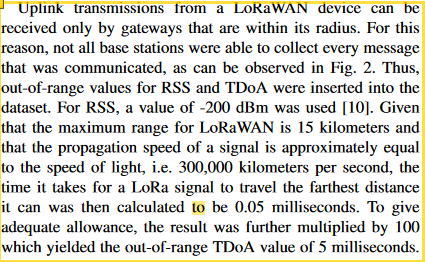

Additionally, in this TDoA measurements, we found out that 
- in 596 cases, the TDoA vaues are greater than 1s. 
- in 250,540 cases, the TDoA vaues are greater than 5ms. 
- in 236,398 cases, the TDoA vaues are greater than 50ms. 
- in 53,999 cases, the TDoA vaues are greater than 0.5s. 
These values are unacceptable. 

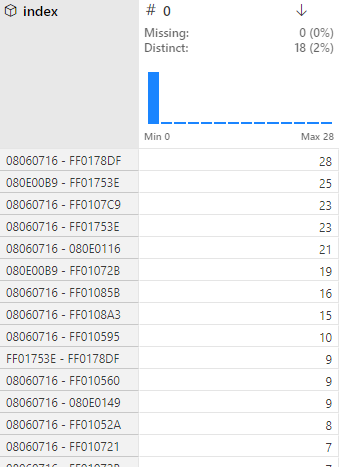

The max value in some case more than thousands of seconds

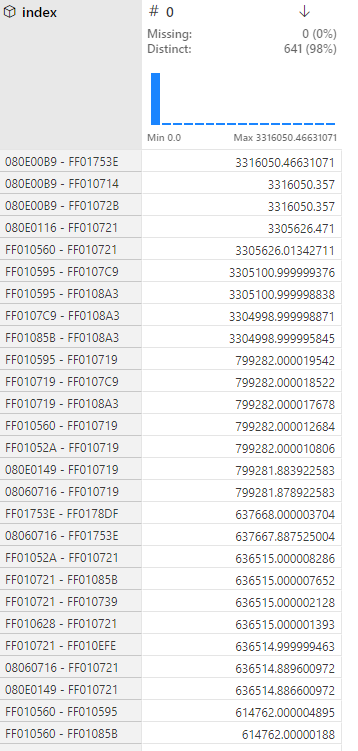

So we set the place holder to 1s. 
### Replacing NaNs and unreal data 

max = tdoa_df.max().dropna()

In [65]:
#### Adding placeholders
tdoa_df_filled = tdoa_df.fillna(.005)
tdoa_df_filled = tdoa_df_filled.where(tdoa_df_filled <= .005, .005)

In [66]:
gt1 = (tdoa_df_filled > 1).sum()
gt1.sum()

max = tdoa_df_filled.max()

In [67]:
ds_rssi_weather_tdoa = pd.merge(ds_clean, tdoa_df_filled, left_on='gw_info_row_id', right_index=True)

In [68]:
ds_rssi_weather_tdoa.to_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/data/antwerp_19_rssi_weather_tdoa.csv')

In [69]:
toa_df.to_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/data/antwerp_19_toa.csv')
tdoa_df_filled.to_csv('D:/work_dir/Datasets/LoRa_anomaly-detection/RSSI_fingerprinting/data/antwerp_19_tdoa.csv')